In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistoryDecay,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)

from src.retrieval.collector import RuleCollector

from src.features import cum_sale, week_sale, repurchase_ratio, purchased_before, popularity

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity
)

In [4]:
data_dir = Path("../src/data/")

In [5]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2
VERSION_NAME = "Large_Recall"

In [6]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)

In [7]:
TEST = False # * Set as `False` when do local experiments to save time

Pepare data: encoding ids and preprocessing

In [8]:
dh = DataHelper(data_dir)

In [9]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [10]:
data = dh.load_data(name="encoded_full")

In [11]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [12]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']

In [13]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'].fillna(22), listBin, labels=[0, 1, 2, 3, 4, 5, 6])
data['user']['age_bins'] = data['user']['age_bins'].astype(int)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [14]:
# for week in range(2, WEEK_NUM):
#     # * use sliding window to generate candidates
#     if week == 0 and not TEST:
#         continue
#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")

#     train, valid = dh.split_data(trans, start_date, end_date)
#     train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
#     train = train.merge(user_info, on='customer_id', how='left')

#     train['t_dat'] = pd.to_datetime(train['t_dat'])
#     last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
#     last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
#     last_24day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=24)]

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         week_num = week,
#         trans_df = trans,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, days=14, n=100),
#             OrderHistoryDecay(train, days=7, n=150),
#             OrderHistoryDecay(train, days=3, n=200),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=200, scale=True, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=200, scale=True, name='3'),
#             TimeHistory(customer_list, last_week, n=200),
#             ItemCF(last_24day, last_2week, top_k=10, name='2'),
#             ItemCF(last_2week, last_2week, top_k=10, name='3'),
#             ItemCF(last_week, last_2week, top_k=10, name='4'),            
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=200).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=150).retrieve(), name='4'),
#             UserGroupItemCF(last_24day, last_2week, 'age_bins', top_k=10, name='2'),
#             UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
#             UserGroupItemCF(last_week, last_2week, 'age_bins', top_k=10, name='4'),
#             UserGroupItemCF(last_24day, last_2week, 'purchase_ability', top_k=10, name='5'),
#             UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
#             UserGroupItemCF(last_week, last_2week, 'purchase_ability', top_k=10, name='4'),
#         ],
#         min_pos_rate=0.0,
#         norm=False,
#         compress=False,
#     )

#     candidates, _ = reduce_mem_usage(candidates)
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#     )
#     rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
#     tmp = candidates[rule_names]
#     for f in rule_names:
#         tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
#     candidates['score'] = tmp[rule_names].sum(axis=1)
#     del tmp
#     gc.collect()
#     candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
#     candidates = candidates[candidates['rank']<=200]
    
#     print(candidates.shape)
#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [15]:
# del train, valid, last_week, last_2week, last_24day
# del customer_list, candidates
# gc.collect()

In [16]:
# for week in range(1):

#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")

#     train, valid = dh.split_data(trans, start_date, end_date)
#     train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
#     train = train.merge(user_info, on='customer_id', how='left')

#     train['t_dat'] = pd.to_datetime(train['t_dat'])
#     last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
#     last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
#     last_24day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=24)]

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         week_num = week,
#         trans_df = trans,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, days=14, n=100),
#             OrderHistoryDecay(train, days=7, n=150),
#             OrderHistoryDecay(train, days=3, n=200),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=200, scale=True, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=200, scale=True, name='3'),
#             TimeHistory(customer_list, last_week, n=200),
#             ItemCF(last_24day, last_2week, top_k=10, name='2'),
#             ItemCF(last_2week, last_2week, top_k=10, name='3'),
#             ItemCF(last_week, last_2week, top_k=10, name='4'),            
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=200).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=150).retrieve(), name='4'),
#             UserGroupItemCF(last_24day, last_2week, 'age_bins', top_k=10, name='2'),
#             UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
#             UserGroupItemCF(last_week, last_2week, 'age_bins', top_k=10, name='4'),
#             UserGroupItemCF(last_24day, last_2week, 'purchase_ability', top_k=10, name='5'),
#             UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
#             UserGroupItemCF(last_week, last_2week, 'purchase_ability', top_k=10, name='4'),
#         ],
#         min_pos_rate=0.0,
#         norm=False,
#         compress=False,
#     )

#     candidates, _ = reduce_mem_usage(candidates)
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#     )
#     rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
#     tmp = candidates[rule_names]
#     for f in rule_names:
#         tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
#     candidates['score'] = tmp[rule_names].sum(axis=1)
#     del tmp
#     gc.collect()
#     candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
#     candidates = candidates[candidates['rank']<=200]
    
#     print(candidates.shape)
#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [17]:
# del train, valid, last_week, last_2week, last_24day
# del customer_list, candidates
# gc.collect()

## Feature engineering


In [18]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [19]:
# # merge `product_code`
# data['user']['age_bucket'] = pd.cut(data['user']['age'].fillna(22), [-1, 19, 29, 39, 49, 59, 69, 119],
#                                     labels=[0, 1, 2, 3, 4, 5, 6])
# inter = inter.merge(item[["article_id", "product_code", "department_no"]], on="article_id", how="left")
# inter = inter.merge(user[["customer_id", "age_bucket"]], on="customer_id", how="left")
# inter["age_bucket"] = inter["age_bucket"].astype(int)
# # calculate week number
# inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
# inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [20]:
# inter["i_sale"] = week_sale(inter, ["article_id"])
# inter["p_sale"] = week_sale(inter, ["product_code"])
# inter["i_sale_uni"] = week_sale(inter, ["article_id"], True)
# inter["p_sale_uni"] = week_sale(inter, ["product_code"], True)
# inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1) # * last week sale
# inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1)
# inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1)
# inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1)

# inter["i_sale_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"])
# inter["p_sale_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"])
# inter["i_sale_uni_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"], True)
# inter["p_sale_uni_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"], True)

# inter["i_sale_by_age"] = week_sale(inter, ["article_id","age_bins"])
# inter["p_sale_by_age"] = week_sale(inter, ["product_code","age_bins"])
# inter["i_sale_by_dept"] = week_sale(inter, ["article_id","department_no"])
# inter["p_sale_by_dept"] = week_sale(inter, ["product_code","department_no"])
# inter["i_sale_by_dept_channel"] = week_sale(inter, ["article_id","department_no","sales_channel_id"])
# inter["p_sale_by_dept_channel"] = week_sale(inter, ["product_code","department_no","sales_channel_id"])

# inter["i_sale_uni_by_age"] = week_sale(inter, ["article_id","age_bucket"], True)
# inter["p_sale_uni_by_age"] = week_sale(inter, ["product_code","age_bucket"], True)
# inter["lw_i_sale_by_age"] = week_sale(inter, ["article_id","age_bucket"], step=1)
# inter["lw_p_sale_by_age"] = week_sale(inter, ["product_code","age_bucket"], step=1)

# inter["i_sale_by_channel_age"] = week_sale(inter, ["article_id","sales_channel_id","age_bucket"])
# inter["p_sale_by_channel_age"] = week_sale(inter, ["product_code","sales_channel_id","age_bucket"])
# inter["i_sale_uni_by_channel_age"] = week_sale(inter, ["article_id","sales_channel_id","age_bucket"], True)
# inter["p_sale_uni_by_channel_age"] = week_sale(inter, ["product_code","sales_channel_id","age_bucket"], True)
# inter["i_sale_by_dept_age"] = week_sale(inter, ["article_id","department_no","age_bucket"])
# inter["p_sale_by_dept_age"] = week_sale(inter, ["product_code","department_no","age_bucket"])

# inter["lw_i_sale_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"], step=1)
# inter["lw_p_sale_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"], step=1)

# inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
# inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
# inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
# inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

# inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
# inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
# inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
# inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

# inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
# inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

# item_feats = [
#     "product_type_no",
#     "product_group_name",
#     "graphical_appearance_no",
#     "colour_group_code",
#     "perceived_colour_value_id",
#     "perceived_colour_master_id",
# ]
# inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

# for f in tqdm(item_feats):
#     inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale")
#     inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1)
#     inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)
    
# inter = inter.drop(columns=item_feats)

Repurchase Ratio

In [21]:
# inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
# inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

# inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
# inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [22]:
# inter.to_parquet(data_dir / "interim/processed_inter.pqt")
# inter.to_parquet(data_dir / "interim/processed_inter_v2.pqt")
# inter.to_parquet(data_dir / "interim/processed_inter_v3.pqt")

In [23]:
inter = pd.read_parquet(data_dir / "interim/processed_inter_v3.pqt")
data["inter"] = inter

article_cluster = pd.read_parquet(data_dir/'articles_new.parquet')
# https://www.kaggle.com/code/beezus666/k-means-and-feature-importance-for-articles/notebook?scriptVersionId=94269787

itemid2idx = pickle.load(open(data_dir/"index_id_map/item_id2index.pkl", "rb"))
article_cluster['article_id'] = article_cluster['article_id'].map(itemid2idx)
article_cluster = article_cluster.rename(columns={'department_no':'department_no_cluster', 'ct':'cluster'})

In [24]:
# #* embeddings from DSSM model
# dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
# dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)\
# # * embeddings from YouTubeDNN model
# yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
# yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

# for i in tqdm(range(1, WEEK_NUM)):
        
#     candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
#     # * merge features
#     candidate = merge_week_data(data, i, candidate)
#     candidate = candidate.merge(article_cluster[['article_id','colour_group_name_cat_cat_code', 'cluster',
#                                                          'department_no_cluster']],  on='article_id', how='left')
    
#     candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
#     candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
#     candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    
# del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd, itemid2idx

In [25]:
# article_cluster = pd.read_parquet(data_dir/'articles_new.parquet')
# # https://www.kaggle.com/code/beezus666/k-means-and-feature-importance-for-articles/notebook?scriptVersionId=94269787

# itemid2idx = pickle.load(open(data_dir/"index_id_map/item_id2index.pkl", "rb"))
# article_cluster['article_id'] = article_cluster['article_id'].map(itemid2idx)
# article_cluster = article_cluster.rename(columns={'department_no':'department_no_cluster', 'ct':'cluster'})

# #* embeddings from DSSM model
# dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
# dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)\
# # * embeddings from YouTubeDNN model
# yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
# yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

# for i in tqdm(range(1)):
        
#     candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
#     # * merge features
#     candidate = merge_week_data(data, i, candidate)
#     candidate = candidate.merge(article_cluster[['article_id','colour_group_name_cat_cat_code', 'cluster',
#                                                          'department_no_cluster']],  on='article_id', how='left')
    
#     candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
#     candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
#     candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    
# del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd, itemid2idx


## Ranking


In [26]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [00:33<00:00,  6.64s/it]


In [27]:
candidates[1].columns.tolist()

['customer_id',
 'article_id',
 'ItemCF_2',
 'ItemCF_3',
 'ItemCF_4',
 'ItemPairRetrieve_1',
 'ItemPairRetrieve_2',
 'ItemPairRetrieve_3',
 'ItemPairRetrieve_4',
 'OrderHistoryDecay_1',
 'OrderHistory_1',
 'TimeHistory_1',
 'UGItemCF_2',
 'UGItemCF_3',
 'UGItemCF_4',
 'UGItemCF_5',
 'UGItemCF_6',
 'UGTimeHistory_1',
 'UGTimeHistory_3',
 'score',
 'rank',
 'label',
 'week',
 't_dat',
 'price',
 'sales_channel_id',
 'product_code',
 'department_no',
 'i_sale',
 'p_sale',
 'i_sale_uni',
 'p_sale_uni',
 'lw_i_sale',
 'lw_p_sale',
 'lw_i_sale_uni',
 'lw_p_sale_uni',
 'i_sale_by_channel',
 'p_sale_by_channel',
 'i_sale_uni_by_channel',
 'p_sale_uni_by_channel',
 'i_sale_by_age',
 'p_sale_by_age',
 'i_sale_by_dept',
 'p_sale_by_dept',
 'i_sale_by_dept_channel',
 'p_sale_by_dept_channel',
 'lw_i_sale_by_channel',
 'lw_p_sale_by_channel',
 'i_sale_ratio',
 'i_sale_uni_ratio',
 'lw_i_sale_ratio',
 'lw_i_sale_uni_ratio',
 'i_uni_ratio',
 'p_uni_ratio',
 'lw_i_uni_ratio',
 'lw_p_uni_ratio',
 'i_sa

In [28]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "rank",
        "score",
        "prob"
    ]
]

cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
    "user_gender",
    "article_gender",
    'age_bucket',
    "season_type",
    'colour_group_name_cat_cat_code',
    'cluster',
    'department_no_cluster'
]

In [29]:
# * convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    elif feat in article_cluster.columns:
        value_set = set(article_cluster[feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 21/21 [00:01<00:00, 19.27it/s]


### Train


In [30]:
full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))

In [31]:
train = full_data[full_data["week"] != 1]
valid = full_data[full_data["week"] == 1]

del full_data

In [32]:
sum(train['label']==0) / len(train)

# 0.994541076811467 4-week 
# 0.997188698975969 6-week 
# 0.9970660423670532 4 week

In [33]:
train = train.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=['customer_id'],ascending=True).reset_index(drop=True)

In [34]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int")
train_group = train_group.groupby(["week","customer_id"])['article_id'].count().values

valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int")
valid_group = valid_group.groupby(["customer_id"])['article_id'].count().values

In [35]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.0123,
    "verbose": -1,
    "eval_at": 12,
}

# params = {
#     "objective": "binary",
#     "boosting_type": "gbdt",
#     "metric": "auc",
#     "max_depth": -1,
#     "num_leaves": 128,
#     "learning_rate": 0.03,
#     "verbose": -1,
# }

In [36]:
train_set = lgb.Dataset(
    data=train[feats],
    label=train["label"],
    group=train_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

valid_set = lgb.Dataset(
    data=valid[feats],
    label=valid["label"],
    group=valid_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

In [37]:
ranker = lgb.train(
    params,
    train_set,
    num_boost_round=300,
    valid_sets=[valid_set],
    early_stopping_rounds=30,
    verbose_eval=10
)

ranker.save_model(data_dir / "interim/lgbranker_md8_wk4.model", num_iteration=ranker.best_iteration)

# 0.766223 6-week
# [139]	valid_0's map@12: 0.766937 6-week

Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.70002
[20]	valid_0's map@12: 0.7007
[30]	valid_0's map@12: 0.700784
[40]	valid_0's map@12: 0.701253
[50]	valid_0's map@12: 0.701172
[60]	valid_0's map@12: 0.701025
[70]	valid_0's map@12: 0.700967
Early stopping, best iteration is:
[46]	valid_0's map@12: 0.701304


Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.76505
[20]	valid_0's map@12: 0.765355
[30]	valid_0's map@12: 0.765275
[40]	valid_0's map@12: 0.765944
[50]	valid_0's map@12: 0.766044
[60]	valid_0's map@12: 0.766384
[70]	valid_0's map@12: 0.766173
[80]	valid_0's map@12: 0.76643
[90]	valid_0's map@12: 0.76658
[100]	valid_0's map@12: 0.766594
[110]	valid_0's map@12: 0.766346
[120]	valid_0's map@12: 0.766337
[130]	valid_0's map@12: 0.766628
[140]	valid_0's map@12: 0.766887
[150]	valid_0's map@12: 0.766415
[160]	valid_0's map@12: 0.766348
Early stopping, best iteration is:
[139]	valid_0's map@12: 0.766937


<Figure size 576x1152 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

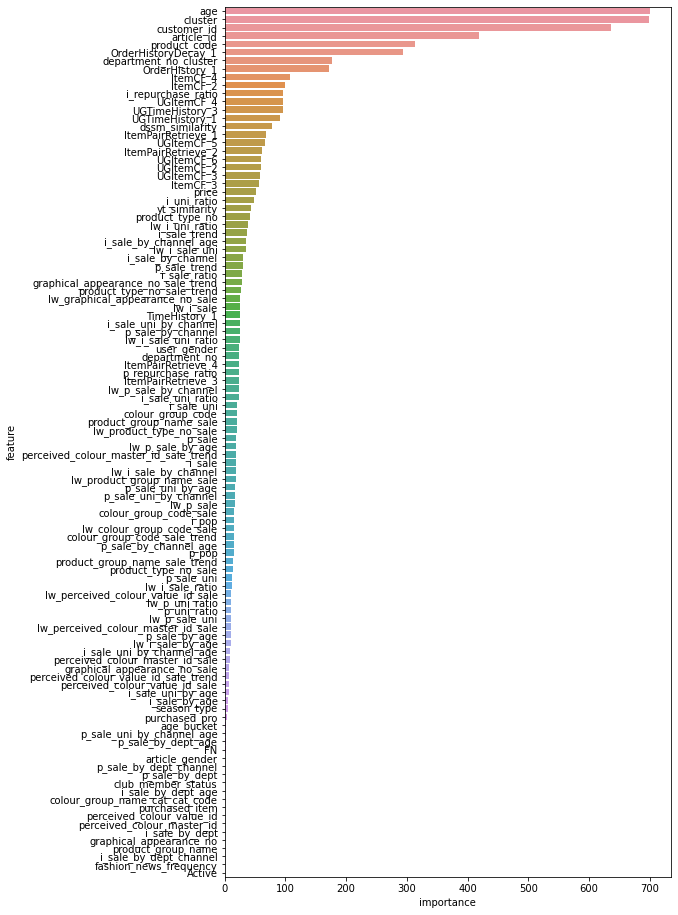

In [49]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 16))
sns.barplot(y="feature", x="importance", data=feat_importance)

<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

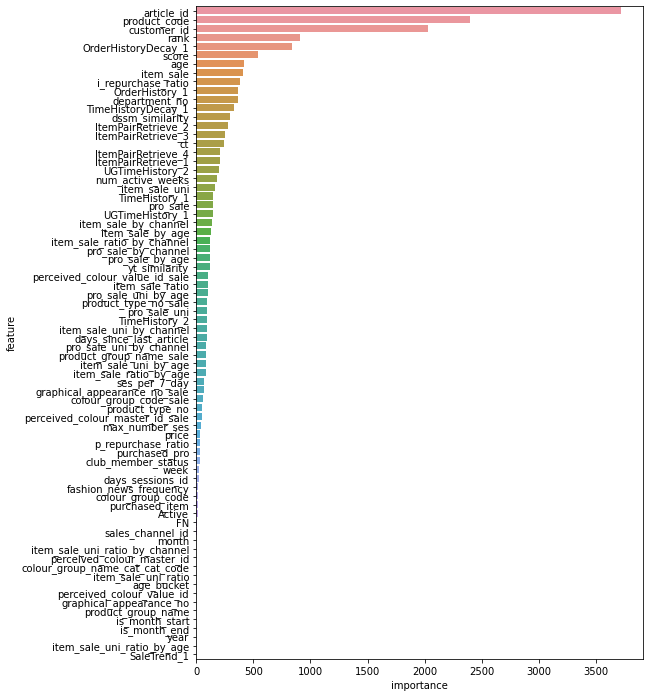

In [ ]:
# ranker = lgb.Booster(model_file=data_dir / "interim/lgb_ranker_new.model")

### Inference

### Validate

In [39]:
val_candidates = valid.reset_index(drop=True)

In [40]:
probs = np.zeros(val_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, val_candidates.shape[0], batch_size)):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 3/3 [00:18<00:00,  6.11s/it]


In [41]:
val_candidates["prob"] = probs

In [42]:
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [43]:
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')

In [44]:
pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 84775/84775 [00:05<00:00, 15417.98it/s]


In [45]:
label = labels[1]
label = pd.merge(label, pred_lgb, on="customer_id", how="left")

In [46]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.026745268910027542 4 week
# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028297597743100006 6 week 0.0250

# 0.02863472423766257 4 week
# 0.02882844782917304 4 week
# 0.028909064246733205 4 week
# 0.029366338019601947 4 week # 0.0268

# 0.029402247883421353 6 week

0.026542230103839166

### Test

In [62]:
test_candidates = candidates[0].reset_index(drop=True)

In [63]:
# As the threshold is set mannually when generating candidates for test set, we need to change the name of the columns
test_candidates.rename(columns = {
    'SaleTrend_7_top4':'SaleTrend_7_top50', 
    'TimeHistoryDecay_3_top31':'TimeHistoryDecay_3_top50',
    'TimeHistoryDecay_7_top24':'TimeHistoryDecay_7_top50',
    'TimeHistory_25_1':'TimeHistory_50_1', 
    'TimeHistory_30_2':'TimeHistory_50_2', 
    'UGSaleTrend_3_top2':'UGSaleTrend_7_top50', 
    'UGTimeHistory_age_bins_351':'UGTimeHistory_age_bins_501',
    'UGTimeHistory_age_bins_38.52':'UGTimeHistory_age_bins_502'
},inplace=True)

In [64]:
probs = np.zeros(test_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 20/20 [04:12<00:00, 12.61s/it]


In [65]:
test_candidates["prob"] = probs

In [66]:
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [67]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [68]:
pred_lgb['prediction'] = pred_lgb['prediction'].map(idx2iid).progress_apply(lambda x:'0'+str(x))
pred_lgb = pred_lgb.groupby('customer_id')['prediction'].progress_apply(list).reset_index()
pred_lgb['prediction'] = pred_lgb['prediction'].progress_apply(lambda x: ' '.join(x[:12]))

100%|██████████| 1371980/1371980 [00:02<00:00, 474615.61it/s]


In [69]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [70]:
del submission['prediction']
submission = submission.merge(pred_lgb, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [71]:
submission.to_csv('submission.csv.gz', index=False)

In [72]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0779781015 0158340001 0918522001 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0448509014 0918292001 0866731001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0918522001 0448509014 06...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0918522001 0158340001 0751471043 0915529003 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0791587001 0927530006 0852584001 07...


### Submit

In [73]:
submit_msg = """
0.029402247883421353 6-week
---
OrderHistory(train, 3),
OrderHistory(train, 7),
OrderHistoryDecay(train, 3, n=50),
OrderHistoryDecay(train, 7, n=50),
ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),
TimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),
TimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),
TimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),
TimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),
SaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)
---
min_pos_rate = 0.005 new features
pivot
"""

In [74]:
submit_msg

"\n0.029402247883421353 6-week\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTre

In [75]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f "submission.csv.gz" -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'


100%|######################################| 69.4M/69.4M [00:03<00:00, 19.2MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations